# Topic Visualization

Visualize topic distributions of Posts from enhanced Topic Model (topic_tokenizer2 and enhanced preprocessing).

In [1]:
import os, sys, ast
sys.path.append("..")
from config import credentials
import dropbox

import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import altair as alt
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
random_state = 23

## Loading

In [3]:
team_dbx = dropbox.DropboxTeam(credentials.dropbox_team_access_token)
team_root = team_dbx.with_path_root(dropbox.common.PathRoot.namespace_id(
    credentials.dropbox_team_namespace_id))
user_dbx = team_root.as_user(credentials.dropbox_team_member_id)

In [4]:
data_path = "/Data/CSVData"
model_path = "../models"
figures_path = "../reports/figures/"

In [5]:
topics20_fpath = os.path.join(data_path, "topics", "final_topics_LDAn20.csv")
_, res = user_dbx.files_download(topics20_fpath)
topics20 = pd.read_csv(res.raw)

posts_fpath = os.path.join(data_path, "PolPosts.csv")
_, res = user_dbx.files_download(posts_fpath)
posts = pd.read_csv(res.raw)

print("Topics n20", topics20.shape)
print("All Posts", posts.shape)

Topics n20 (21970, 4)
All Posts (27204, 23)


## Postprocess topics

Join Posts with Topic tables and assign topics to duplicated texts.

In [6]:
# Join
data = posts.set_index("textID").join(topics20.set_index("textID"), lsuffix="_posts", rsuffix="_topics")

# Assign topics to duplicated texts
data.topic = data.topic.astype("Int64")
data.topic = data.groupby("text_posts")["topic"].ffill()

# Cleaning
data["source"] = data.Site
data.drop(["text_topics", "Site"], axis=1, inplace=True)
data.dropna(subset=["text_posts", "topic"], inplace=True)

data.shape

(23384, 24)

## Topic Interpretation

In [7]:
topic_interpretation = {0: "-", 1: "-", 2: "Wohnen/Sicherheit", 3: "Grüne",
                        4: "Steuern/Geld", 5: "TV", 6: "Parteien", 
                        7: "Prognosen", 8: "KPÖ/LinkeVorderungen", 9: "Dank/TV-Runde",
                        10: "Links/Alternativ", 11: "ÖVP", 12: "-",
                        13: "SPÖ", 14: "Volksparteien", 15: "-", 16: "FPÖ",
                        17: "-", 18: "Wahlkampfslogans", 19: "-", 20: "Rechts-außen"}

data["topic_interpretation"] = data.topic.map(topic_interpretation)

## Exploration & Visualization

### Posts per topic

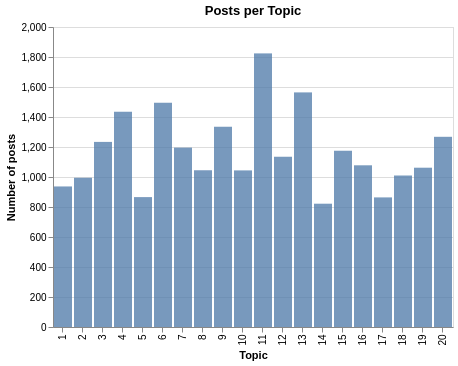

In [8]:
p_data = data.topic.value_counts().to_frame("count").rename_axis("topic").reset_index()
p_data["topic_interpretation"] = p_data.topic.map(topic_interpretation)

chart = alt.Chart(p_data, title="Posts per Topic").mark_bar().encode(
    x=alt.X("topic:N", title="Topic"),
    y=alt.Y("count:Q", title="Number of posts"),
    opacity=alt.value(0.75),
    tooltip=[alt.Tooltip("topic_interpretation", title="Interpretation")]
)

chart.save(os.path.join(figures_path, "topics", "LDAn20_posts_per_topic.html"))
chart

Top-20 Posts per Topic

In [9]:
def get_top_20(df, topic, topic_range):
    topic_subset = df[df.topic == topic].copy()
    topic_subset.topic_distribution = topic_subset.topic_distribution.apply(ast.literal_eval)
    flattend_subset = pd.concat([topic_subset,
                                pd.DataFrame(topic_subset.topic_distribution.values.tolist(),
                                             index=topic_subset.index, columns=topic_range)],
                               axis=1)
    return flattend_subset.sort_values(by=[topic], ascending=False).text.head(20)

In [10]:
topics20_top20_fp = "../reports/topics_n20_top-20.txt"
topic_range = range(1, 21)

with open(topics20_top20_fp, "w") as f:
    for i in topic_range:
        with pd.option_context("display.max_colwidth", -1):
            f.write("Topic " + str(i) + ":\n" + get_top_20(topics20, i, topic_range).to_string(index=False) + "\n\n")

### Interactions per topic

Total interactions

In [11]:
grouped = data.groupby(["topic", "topic_interpretation"]).agg({"interactionCount": ["count", "sum", "mean"]})
pd.set_option("display.max_rows", None)
grouped

interactionCount                    
                                      count     sum        mean
topic topic_interpretation                                     
1     -                                 937  105285  112.363927
2     Wohnen/Sicherheit                 995  144655  145.381910
3     Grüne                            1234  176640  143.144246
4     Steuern/Geld                     1435  255748  178.221603
5     TV                                866  132610  153.129330
6     Parteien                         1495  217015  145.160535
7     Prognosen                        1196  176082  147.225753
8     KPÖ/LinkeVorderungen             1045  130028  124.428708
9     Dank/TV-Runde                    1335  196337  147.068914
10    Links/Alternativ                 1044  148251  142.002874
11    ÖVP                              1824  482425  264.487390
12    -                                1135  157714  138.955066
13    SPÖ                              1564  295396  188.872123
14    Volksparteien                     822  138625  168.643552
15    -                                1175  227565  193.672340
16    FPÖ                              1078  261477  242.557514
17    -                                 864  115372  133.532407
18    Wahlkampfslogans                 1010  183748  181.928713
19    -                                1062  147963  139.324859
20    Rechts-außen                     1268  215937  170.297319

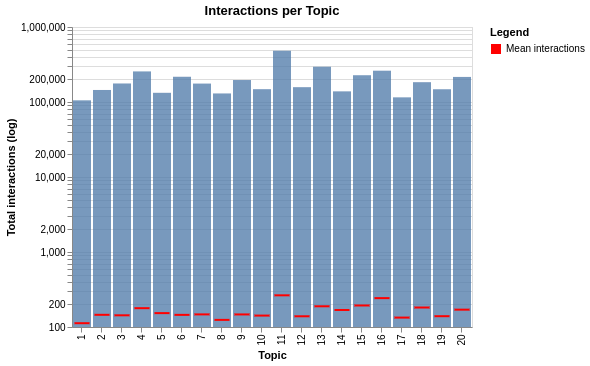

In [12]:
grouped.columns = ["count", "sum", "mean"]
p_data = grouped.reset_index().round(2)
p_data["Topic"] = p_data.topic_interpretation
p_data["bar_label"] = ["Total interactions"] * p_data.shape[0]
p_data["mean_label"] = ["Mean interactions"] * p_data.shape[0]

bars = alt.Chart(p_data, title="Interactions per Topic").mark_bar().encode(
    x=alt.X("topic:N", title="Topic"),
    y=alt.Y("sum:Q",
            scale=alt.Scale(type="log", base=10),
            title="Total interactions (log)"),
    opacity=alt.value(0.75),
    tooltip=[alt.Tooltip("Topic", title="Topic"),
             alt.Tooltip("count", title="Posts"),
             alt.Tooltip("sum", title="Total interactions"),
             alt.Tooltip("mean", title="Mean interactions")]
)

mean_ticks = alt.Chart(p_data).mark_tick(color="red", thickness=2).encode(
    x=alt.X("topic:N", title="Topic"),
    y=alt.Y("mean:Q",
            scale=alt.Scale(type="log", base=10),
            title=""),
    color=alt.Color("mean_label",
                    scale=alt.Scale(range=["red"], domain=["Mean interactions"]), 
                    title="Legend"),
    opacity=alt.value(1)
)

chart = bars + mean_ticks
chart.save(os.path.join(figures_path, "topics", "interactions_per_topic.html"))
chart

Interactions per source

In [13]:
grouped = data.groupby(["topic", "topic_interpretation", "source"]).agg({"interactionCount": ["count", "sum", "mean"]})
pd.set_option("display.max_rows", None)
grouped

interactionCount                    
                                               count     sum        mean
topic topic_interpretation source                                       
1     -                    Facebook              469   88713  189.153518
                           Twitter               468   16572   35.410256
2     Wohnen/Sicherheit    Facebook              524  132659  253.166031
                           Twitter               471   11996   25.469214
3     Grüne                Facebook              602  159577  265.078073
                           Twitter               632   17063   26.998418
4     Steuern/Geld         Facebook              707  227364  321.589816
                           Twitter               728   28384   38.989011
5     TV                   Facebook              449  113189  252.091314
                           Twitter               417   19421   46.573141
6     Parteien             Facebook              719  194006  269.827538
                           Twitter               776   23009   29.650773
7     Prognosen            Facebook              634  149874  236.394322
                           Twitter               562   26208   46.633452
8     KPÖ/LinkeVorderungen Facebook              492  115130  234.004065
                           Twitter               553   14898   26.940325
9     Dank/TV-Runde        Facebook              544  167913  308.663603
                           Twitter               791   28424   35.934260
10    Links/Alternativ     Facebook              518  133007  256.770270
                           Twitter               526   15244   28.980989
11    ÖVP                  Facebook             1099  452139  411.409463
                           Twitter               725   30286   41.773793
12    -                    Facebook              626  141228  225.603834
                           Twitter               509   16486   32.388998
13    SPÖ                  Facebook              809  273951  338.629172
                           Twitter               755   21445   28.403974
14    Volksparteien        Facebook              428  128653  300.591121
                           Twitter               394    9972   25.309645
15    -                    Facebook              587  211253  359.885860
                           Twitter               588   16312   27.741497
16    FPÖ                  Facebook              621  249352  401.533011
                           Twitter               457   12125   26.531729
17    -                    Facebook              473  105266  222.549683
                           Twitter               391   10106   25.846547
18    Wahlkampfslogans     Facebook              589  167896  285.052632
                           Twitter               421   15852   37.653207
19    -                    Facebook              520  132786  255.357692
                           Twitter               542   15177   28.001845
20    Rechts-außen         Facebook              621  188230  303.107890
                           Twitter               647   27707   42.823802

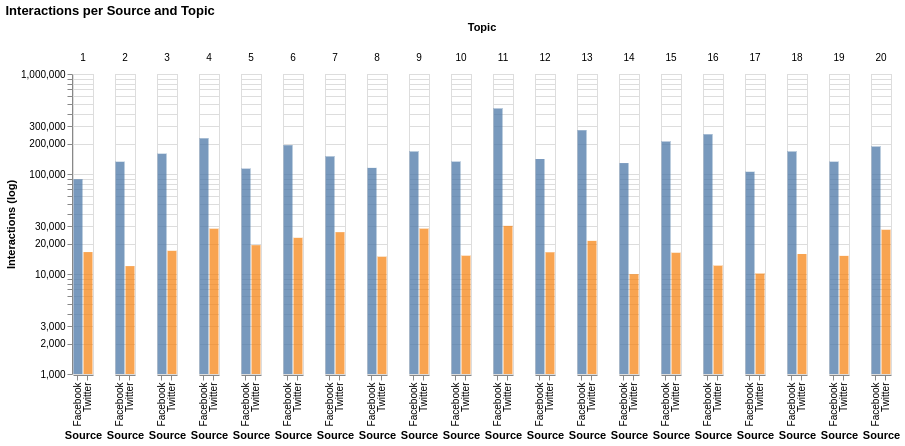

In [14]:
p_data = grouped.copy()
p_data["source"] = p_data.index.get_level_values("source")
p_data.columns = ["count", "sum", "mean", "Source"]
p_data.reset_index(inplace=True)
p_data["Topic"] = p_data.topic_interpretation

chart = alt.Chart(p_data, title="Interactions per Source and Topic").mark_bar().encode(
    alt.X("Source:N"),
    alt.Y("sum(sum):Q", 
          scale=alt.Scale(type="log", base=10),
          title="Interactions (log)"),
    column=alt.Column("topic:O", title="Topic"),
    color=alt.Color("Source", legend=None),
    opacity=alt.value(0.75),
    tooltip=["Topic"]
).properties(
    width=20
)

chart.save(os.path.join(figures_path, "topics", "interactions_per_source_layered.html"))
chart

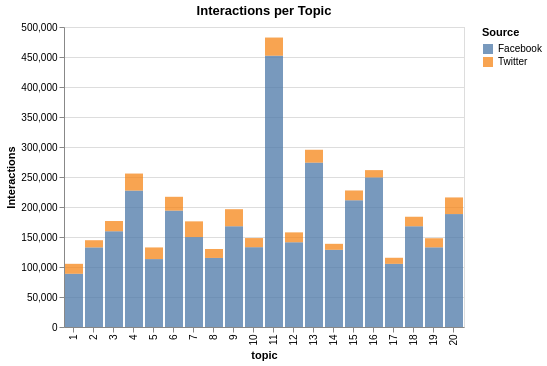

In [15]:
p_data = grouped.copy().round(2)
p_data["source"] = p_data.index.get_level_values("source")
p_data.columns = ["count", "sum", "mean", "Source"]
p_data.reset_index(inplace=True)
p_data["Topic"] = p_data.topic_interpretation
p_data["order"] = p_data.source.map({"Facebook": 0, "Twitter": 1})

chart = alt.Chart(p_data, title="Interactions per Topic").mark_bar().encode(
    alt.X("topic:N"),
    alt.Y("sum(sum):Q", 
          title="Interactions"),
    color=alt.Color("Source"),
    order=alt.Order("order"),
    opacity=alt.value(0.75),
    tooltip=[alt.Tooltip("Topic", title="Topic"),
             alt.Tooltip("source", title="Source"),
             alt.Tooltip("count", title="Posts per source"),
             alt.Tooltip("sum", title="Total interactions per source"),
             alt.Tooltip("mean", title="Mean interactions per source")]
)

chart.save(os.path.join(figures_path, "topics", "interactions_per_source_stacked.html"))
chart

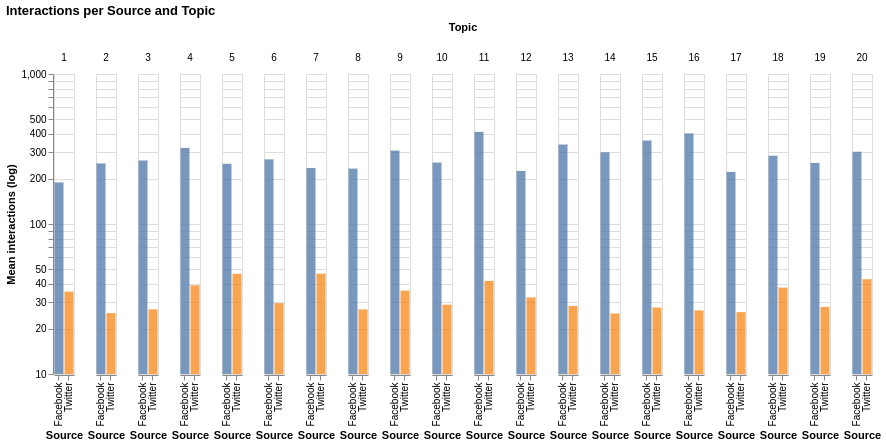

In [16]:
p_data = grouped.copy()
p_data["source"] = p_data.index.get_level_values("source")
p_data.columns = ["count", "sum", "mean", "Source"]
p_data.reset_index(inplace=True)
p_data["Topic"] = p_data.topic_interpretation

chart = alt.Chart(p_data, title="Interactions per Source and Topic").mark_bar().encode(
    alt.X("Source:N"),
    alt.Y("sum(mean):Q", 
          scale=alt.Scale(type="log", base=10),
          title="Mean interactions (log)"),
    column=alt.Column("topic:O", title="Topic"),
    color=alt.Color("Source", legend=None),
    opacity=alt.value(0.75),
    tooltip=["Topic"]
).properties(
    width=20
)

chart.save(os.path.join(figures_path, "topics", "mean_interactions_per_source.html"))
chart